In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import seaborn as sns
import gc
from xgboost import XGBRegressor
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [3]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [4]:
fci_df = pd.read_csv("sample_data/fulfilment_center_info.csv")
mi_df = pd.read_csv("sample_data/meal_info.csv")
train_df = pd.read_csv("sample_data/train.csv")
test_df = pd.read_csv("sample_data/test_QoiMO9B.csv")
sub_df = pd.read_csv("sample_data/sample_submission_hSlSoT6.csv")

In [5]:
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [6]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [7]:
fci_df.isnull().sum()

,0
center_id,0
city_code,0
region_code,0
center_type,0
op_area,0


In [8]:
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [9]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [10]:
mi_df.isnull().sum()

,0
meal_id,0
category,0
cuisine,0


In [11]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [12]:
print("Shape of train: ", train_df.shape)

Shape of train:  (456548, 9)


In [13]:
train_df.isnull().sum()

,0
id,0
week,0
center_id,0
meal_id,0
checkout_price,0
base_price,0
emailer_for_promotion,0
homepage_featured,0
num_orders,0


In [14]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [15]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [16]:
test_df.isnull().sum()

,0
id,0
week,0
center_id,0
meal_id,0
checkout_price,0
base_price,0
emailer_for_promotion,0
homepage_featured,0


In [17]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [18]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

In [20]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [21]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [22]:
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)[train_df.columns]

In [23]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [24]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [25]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']

In [26]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095


<ipython-input-27-5f00ad411b64>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_df['discount_on_base'], bins=500)


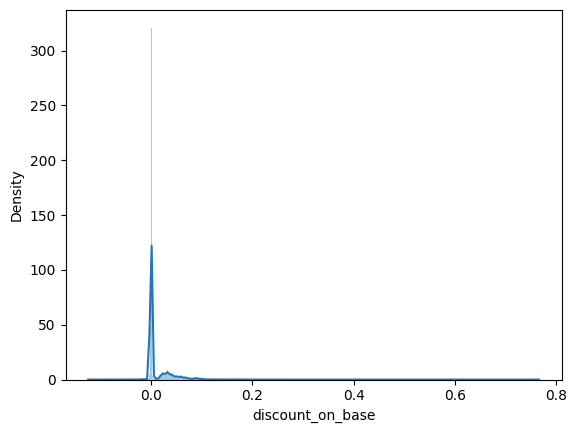

In [27]:
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [28]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)

In [29]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)

In [30]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

In [31]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)

In [32]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)

In [33]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082,1,-0.001037,1
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043,0,0.002077,0
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095,1,-0.001075,1


In [34]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [35]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

In [36]:
# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2,
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w,
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

In [37]:
# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2,
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w,
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

In [38]:
# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [39]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [40]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
all_df = create_sales_lag_feats(all_df, gpby_cols=['center_id','meal_id'], target_col='num_orders',
                               lags=[10,11, 12])
# all_df = create_sales_rmean_feats(all_df, gpby_cols=['center_id','meal_id'], target_col='num_orders',
                                 # windows=[10,11,12,13,14,15])

all_df = create_sales_ewm_feats(all_df, gpby_cols=['center_id','meal_id'],
                               target_col='num_orders',
                               alpha=[0.5],
                               shift=[10,11,12,13,14,15])


In [41]:
all_df.shape

(489121, 29)

In [42]:
show_all(all_df, 5, None)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489119,1429037,115,186,2956,6.366522,6.369952,0,0,2.772589,649,34,TYPE_A,3.4,Fish,Continental,train,0.000539,0,0.000539,0,3.209412,5.595081,3.548507,3.097631,3.556204,3.398836,3.430377,3.564916,3.392163
489120,1285049,116,186,2956,5.680275,6.368239,0,0,4.812184,649,34,TYPE_A,3.4,Fish,Continental,train,0.108030,0,0.107790,0,3.382388,4.074733,5.217146,3.405601,3.097631,3.556204,3.398836,3.430377,3.564916


In [43]:
trn = all_df.loc[all_df['train_or_test']=='train', :]
test = all_df.loc[all_df['train_or_test']=='test', :]

In [44]:
trn.shape

(456548, 29)

In [45]:
test.shape

(32573, 29)

In [46]:
trn.isnull().sum()

,0
id,0
week,0
center_id,0
meal_id,0
checkout_price,0
base_price,0
emailer_for_promotion,0
homepage_featured,0
num_orders,0
city_code,0


# XGBoost


In [47]:
# XGBoost Model
y = trn['num_orders']
trn.drop(['num_orders', 'train_or_test'], inplace=True, axis=1)
test.drop(['num_orders', 'train_or_test'], inplace=True, axis=1)

# Select features - exclude object types
categorical_cols = trn.select_dtypes(include=['object', 'category']).columns
trn = one_hot_encoder(trn, categorical_cols)
test = one_hot_encoder(test, categorical_cols)

# Align columns after one-hot encoding
train_cols = set(trn.columns)
test_cols = set(test.columns)

missing_in_test = list(train_cols - test_cols)
for c in missing_in_test:
    test[c] = 0

missing_in_train = list(test_cols - train_cols)
for c in missing_in_train:
    trn[c] = 0

<ipython-input-47-fffd598ad63c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trn.drop(['num_orders', 'train_or_test'], inplace=True, axis=1)
<ipython-input-47-fffd598ad63c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['num_orders', 'train_or_test'], inplace=True, axis=1)


Creating OHE features..
Old df shape:(456548, 27)
New df shape:(456548, 45)
Creating OHE features..
Old df shape:(32573, 27)
New df shape:(32573, 45)


In [48]:
test = test[trn.columns]
X = trn
X_test = test

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.005,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50 # Add early stopping
}


In [49]:
model_xgb = XGBRegressor(**xgb_params)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=True)

predictions_xgb = model_xgb.predict(X_test)

[0]	validation_0-rmse:1.15906
[1]	validation_0-rmse:1.11942
[2]	validation_0-rmse:1.08229
[3]	validation_0-rmse:1.04688
[4]	validation_0-rmse:1.01374
[5]	validation_0-rmse:0.98272
[6]	validation_0-rmse:0.95386
[7]	validation_0-rmse:0.92659
[8]	validation_0-rmse:0.90117
[9]	validation_0-rmse:0.87744
[10]	validation_0-rmse:0.85555
[11]	validation_0-rmse:0.83481
[12]	validation_0-rmse:0.81562
[13]	validation_0-rmse:0.79827
[14]	validation_0-rmse:0.78134
[15]	validation_0-rmse:0.76566
[16]	validation_0-rmse:0.75082
[17]	validation_0-rmse:0.73738
[18]	validation_0-rmse:0.72448
[19]	validation_0-rmse:0.71248
[20]	validation_0-rmse:0.70139
[21]	validation_0-rmse:0.69115
[22]	validation_0-rmse:0.68186
[23]	validation_0-rmse:0.67319
[24]	validation_0-rmse:0.66511
[25]	validation_0-rmse:0.65745
[26]	validation_0-rmse:0.65029
[27]	validation_0-rmse:0.64357
[28]	validation_0-rmse:0.63732
[29]	validation_0-rmse:0.63144
[30]	validation_0-rmse:0.62626
[31]	validation_0-rmse:0.62143
[32]	validation_0-

KeyboardInterrupt: 

In [50]:
# Inverse transform the predictions
predictions_xgb = np.expm1(predictions_xgb)

predictions_xgb[predictions_xgb < 0] = 0
predictions_xgb = np.round(predictions_xgb).astype(int)

NameError: name 'predictions_xgb' is not defined

In [51]:
# submission file
sub_df['num_orders'] = predictions_xgb
sub_df.to_csv('xgb_submission.csv', index=False)

NameError: name 'predictions_xgb' is not defined

### Catboost

In [ ]:
avoid_columns1 = ['id', 'num_orders', 'train_or_test', 'checkout_price', 'base_price', 'city_code', 'region_code', 'center_type', '']

In [ ]:
features1 = [col for col in test.columns if col not in avoid_columns1]

In [ ]:
features1

In [ ]:
cat_ind1 = [1, 2, 3, 4, 6, 7, 9, 11]

In [ ]:
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)

In [ ]:
cat_rg1.fit(X=trn[features1], y=trn['num_orders'], cat_features=cat_ind1, verbose=True)

624:	learn: 0.4839052	total: 8m 15s	remaining: 0us

In [ ]:
pred = cat_rg1.predict(test[features1])

In [ ]:
pred = (np.exp(pred) - 1)

In [ ]:
sub_df = pd.DataFrame(columns=['id', 'num_orders'])
sub_df['id'] = test['id']
sub_df['num_orders'] = pred
sub_df.to_csv('sample_data/cat10.csv', index=False)